In [ ]:
from google.colab import drive

In [ ]:
# Import required modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count
from pyspark.sql.functions import col, mean
from pyspark.sql import functions as F
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
import time
import numpy as np
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import GBTClassifier




In [ ]:
spark = SparkSession.builder \
    .appName("Telecomunication ") \
    .getOrCreate()

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to your dataset (after uploading to Google Drive)
file_path = "/content/drive/MyDrive/telecom/customer.csv"

In [ ]:
# Load dataset into a Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [ ]:
# Number of rows
print(f"Total Rows: {df.count()}")

# Number of columns
print(f"Total Columns: {len(df.columns)}")

Total Rows: 100000
Total Columns: 100


In [ ]:
# Display schema (column names and data types)
df.printSchema()

root
 |-- rev_Mean: double (nullable = true)
 |-- mou_Mean: double (nullable = true)
 |-- totmrc_Mean: double (nullable = true)
 |-- da_Mean: double (nullable = true)
 |-- ovrmou_Mean: double (nullable = true)
 |-- ovrrev_Mean: double (nullable = true)
 |-- vceovr_Mean: double (nullable = true)
 |-- datovr_Mean: double (nullable = true)
 |-- roam_Mean: double (nullable = true)
 |-- change_mou: double (nullable = true)
 |-- change_rev: double (nullable = true)
 |-- drop_vce_Mean: double (nullable = true)
 |-- drop_dat_Mean: double (nullable = true)
 |-- blck_vce_Mean: double (nullable = true)
 |-- blck_dat_Mean: double (nullable = true)
 |-- unan_vce_Mean: double (nullable = true)
 |-- unan_dat_Mean: double (nullable = true)
 |-- plcd_vce_Mean: double (nullable = true)
 |-- plcd_dat_Mean: double (nullable = true)
 |-- recv_vce_Mean: double (nullable = true)
 |-- recv_sms_Mean: double (nullable = true)
 |-- comp_vce_Mean: double (nullable = true)
 |-- comp_dat_Mean: double (nullable = tr

In [ ]:
#Displaying five basic rows
df.show(5)

+--------+--------+-----------+-------+-----------+-----------+-----------+-----------+---------+----------+----------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-----------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+-------------+-------------+-------------+-------------+------------+------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+-----+------+--------+--------+--------+--------+--------+--------+-----------+-------+-------+--------+------+------+------+------+-------+-------+-------+-------+-------+-------+----------------+--------------------+--------+----------+-----------+------+------+----------+-----+---+-------+---+--------+-------+------+--------+------+--------+--------+-----

In [ ]:
 # Provides summary statistics like mean, min, max
df.describe().show()


+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+-----------------+-------------------+-----------------+--------------------+-----------------+-------------------+------------------+------------------+------------------+--------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+-----------------+------------------+------------------

**Data Cleaning**

In [ ]:
columns = df.columns
# Define a function to count the missing values in each row
missing_count_expr = sum([F.when(F.col(col).isNull(), 1).otherwise(0) for col in columns])

# Add a new column 'missing_count' that stores the number of missing values for each row (customer)
df_with_missing_count = df.withColumn("missing_count", missing_count_expr)

# Show the result
df_with_missing_count.select("customer_id", "missing_count").show()

+-----------+-------------+
|customer_id|missing_count|
+-----------+-------------+
|    1000001|            0|
|    1000002|            2|
|    1000003|            0|
|    1000004|            1|
|    1000005|            0|
|    1000006|            2|
|    1000007|            1|
|    1000008|            1|
|    1000009|            1|
|    1000010|            0|
|    1000011|            1|
|    1000012|            2|
|    1000013|            1|
|    1000014|            2|
|    1000015|            0|
|    1000016|            3|
|    1000017|            0|
|    1000018|            1|
|    1000019|            0|
|    1000020|            0|
+-----------+-------------+
only showing top 20 rows



In [ ]:
# Show percentage of missing values per column
missing_percentage = df.select([(F.count(F.when(F.col(c).isNull(), c))/df.count()).alias(c) for c in df.columns])
missing_percentage.show()

# Show the count of missing values per customer
df_with_missing_count.select("customer_id", "missing_count").groupBy("missing_count").count().show()


+--------+--------+-----------+-------+-----------+-----------+-----------+-----------+---------+----------+----------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-----------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+-------------+-------------+-------------+-------------+------------+------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+-----+------+--------+--------+--------+--------+--------+--------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+----------------+------+--------+----------+---------+------+------+----------+-------+-------+-------+------+--------+-------+-------+--------+-------+--------+--------+--------+--------+-

**Handling Erroneous small values**

In [ ]:
# Replace small values (1.0E-5) with None (null)
df_cleaned = df.select(
    [F.when(F.col(c) == 1.0E-5, None).otherwise(F.col(c)).alias(c) for c in df.columns]
)

# Check for any remaining missing values
df_cleaned.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show()


+--------+--------+-----------+-------+-----------+-----------+-----------+-----------+---------+----------+----------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-----------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+-------------+-------------+-------------+-------------+------------+------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+-----+------+--------+--------+--------+--------+--------+--------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+----------------+----+--------+----------+---------+------+------+----------+-----+----+-------+-----+--------+-------+------+--------+------+--------+--------+--------+--------+------+----

**Handling Missing Values**

In [ ]:
# Impute missing values for continuous columns with mean
continuous_columns = ['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou', 'change_rev','avg6mou','avg6qty','avg6rev']

for column in continuous_columns:
    mean_value = df_cleaned.agg(F.avg(column)).collect()[0][0]
    df_cleaned = df_cleaned.fillna({column: mean_value})

# Check for remaining missing values
df_cleaned.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show()

+--------+--------+-----------+-------+-----------+-----------+-----------+-----------+---------+----------+----------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-----------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+-------------+-------------+-------------+-------------+------------+------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+-----+------+--------+--------+--------+--------+--------+--------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+----------------+----+--------+----------+---------+------+------+----------+-----+----+-------+-----+--------+-------+------+--------+------+--------+--------+--------+--------+------+----

In [ ]:
# Impute missing values for categorical columns with mode
categorical_columns = ['area', 'dualband', 'marital', 'new_cell', 'crclscod', 'area', 'dualband', 'marital','prizm_social_one']  # Add all categorical columns to be imputed

for column in categorical_columns:
    mode_value = df_cleaned.groupBy(column).count().orderBy(F.desc('count')).first()[0]
    df_cleaned = df_cleaned.fillna({column: mode_value})

# Check for remaining missing values
df_cleaned.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show()

+--------+--------+-----------+-------+-----------+-----------+-----------+-----------+---------+----------+----------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-----------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+-------------+-------------+-------------+-------------+------------+------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+-----+------+--------+--------+--------+--------+--------+--------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+----------------+----+--------+----------+---------+------+------+----------+-----+----+-------+-----+--------+-------+------+--------+------+--------+--------+--------+--------+------+----

In [ ]:
# Remove rows with more than 30% missing values
threshold = 0.3
row_count = df_cleaned.count()
missing_threshold = row_count * threshold

df_cleaned = df_cleaned.na.drop(subset=[c for c in df_cleaned.columns if df_cleaned.filter(F.col(c).isNull()).count() > missing_threshold])

# Check for remaining missing values
df_cleaned.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show()


+--------+--------+-----------+-------+-----------+-----------+-----------+-----------+---------+----------+----------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-----------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+-------------+-------------+-------------+-------------+------------+------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+-----+------+--------+--------+--------+--------+--------+--------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+----------------+----+--------+----------+---------+------+------+----------+-----+---+-------+---+--------+-------+------+--------+------+--------+--------+--------+--------+------+------+

**Checking for duplicate records**

In [ ]:

# Count total rows
total_rows = df.count()

# Drop duplicates and count remaining rows
df_no_duplicates = df.dropDuplicates()
remaining_rows = df_no_duplicates.count()

# Calculate number of duplicate rows
num_duplicates = total_rows - remaining_rows

print(f"Number of duplicate rows: {num_duplicates}")


Number of duplicate rows: 0


**EXPLORATORY DATA ANALYSIS(EDA)**

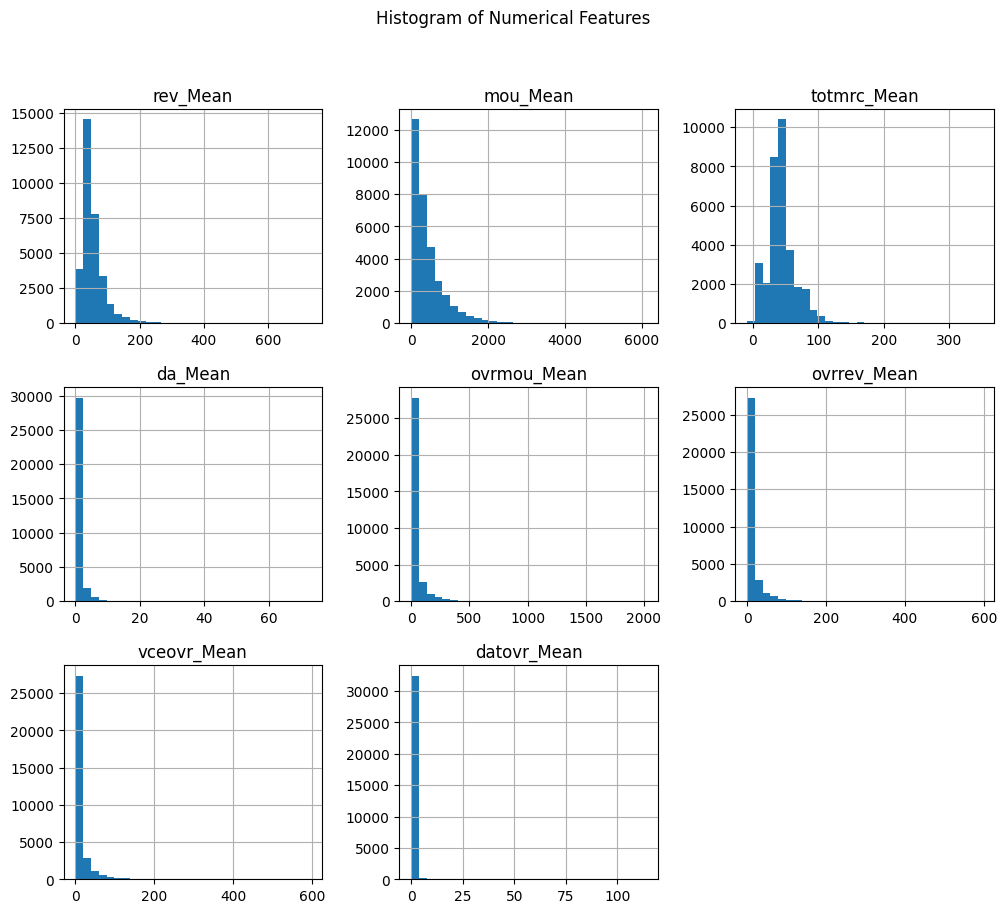

In [ ]:
#Univariate Analysis
#A. Distribution of Numerical Features
# Convert Spark DataFrame to Pandas for visualization
df_pandas = df_cleaned.toPandas()

# Plot histograms for numerical features
numeric_columns = ['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean']  # Adjust this list as needed
df_pandas[numeric_columns].hist(figsize=(12, 10), bins=30)
plt.suptitle("Histogram of Numerical Features")
plt.show()

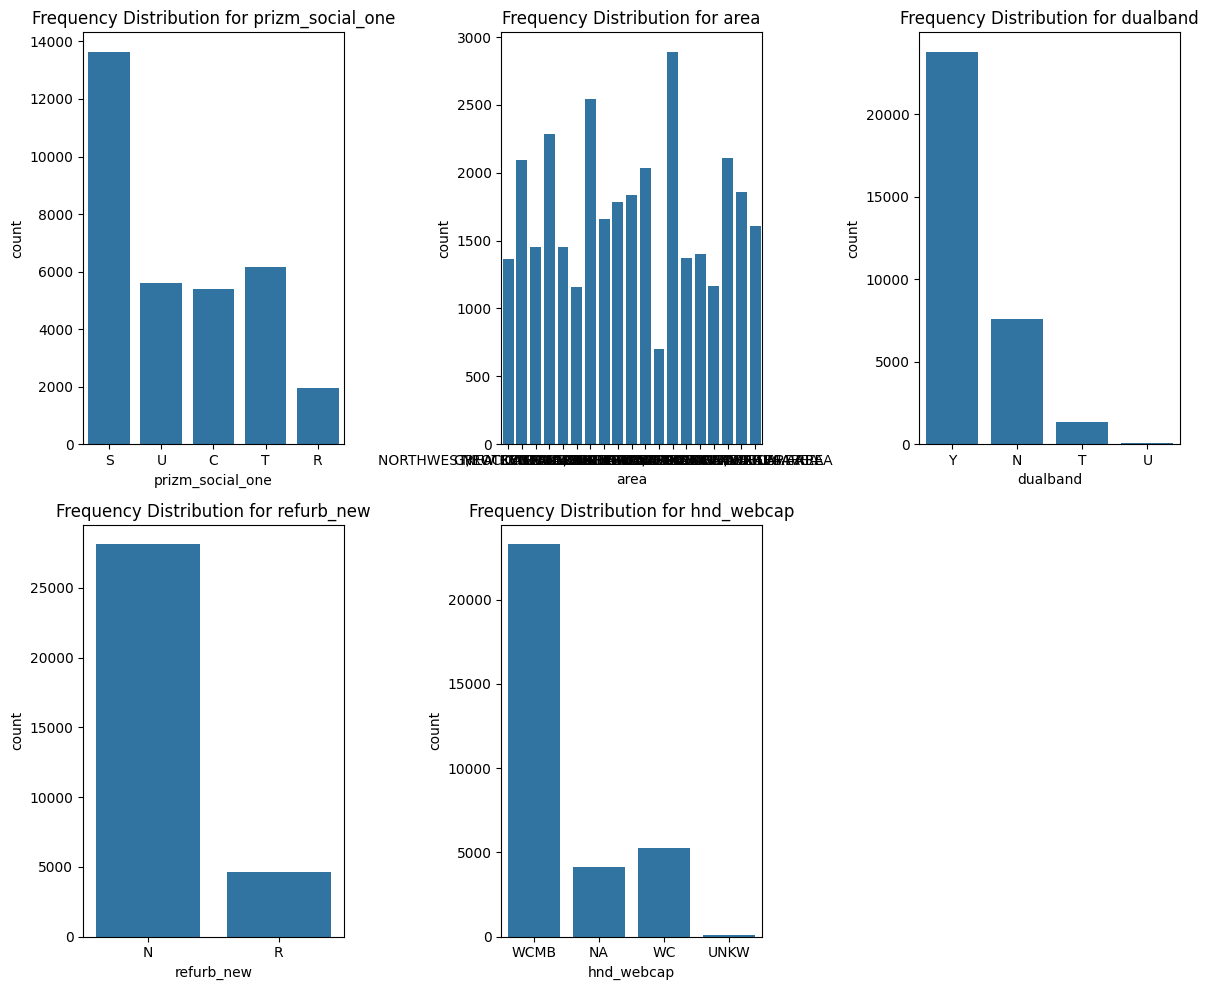

In [ ]:
#Frequency distribution for categorical features
# Categorical columns (adjust if needed)
categorical_columns = ['prizm_social_one', 'area', 'dualband', 'refurb_new', 'hnd_webcap']

# Plot frequency distribution for categorical features
plt.figure(figsize=(12, 10))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 3, i)  # Adjust the layout as needed
    sns.countplot(data=df_pandas, x=col)
    plt.title(f'Frequency Distribution for {col}')
plt.tight_layout()
plt.show()

**BIVARIATE ANALYSIS**

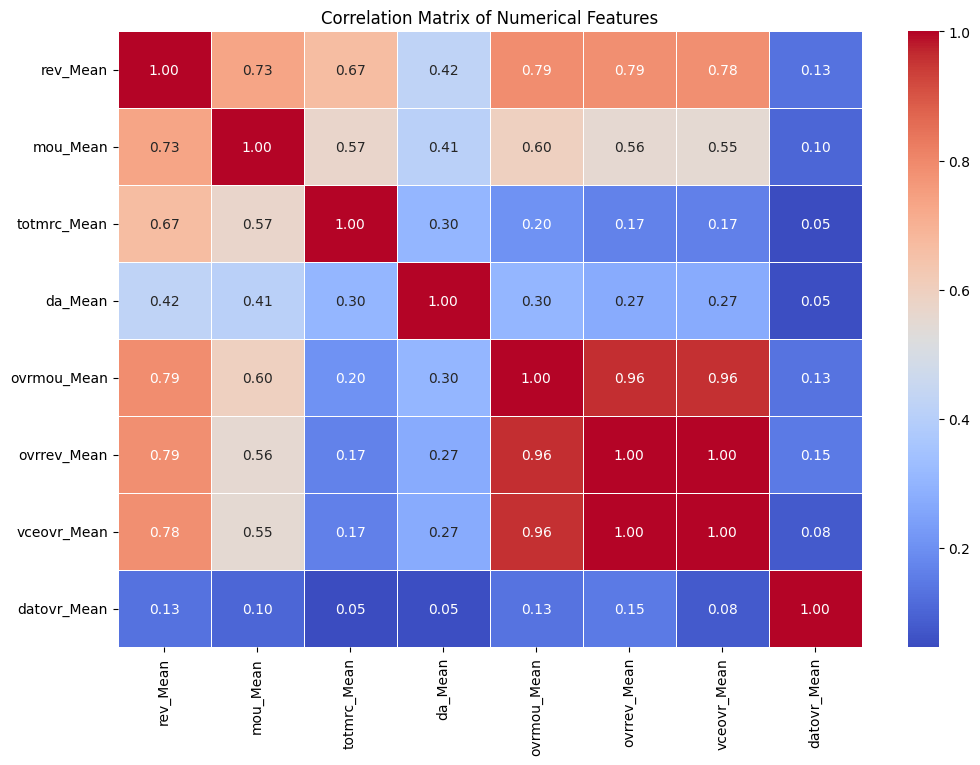

In [ ]:
# A. Correlation Matrix (for Numerical Features)
# Correlation matrix to identify relationships between numerical features
corr_matrix = df_pandas[numeric_columns].corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()



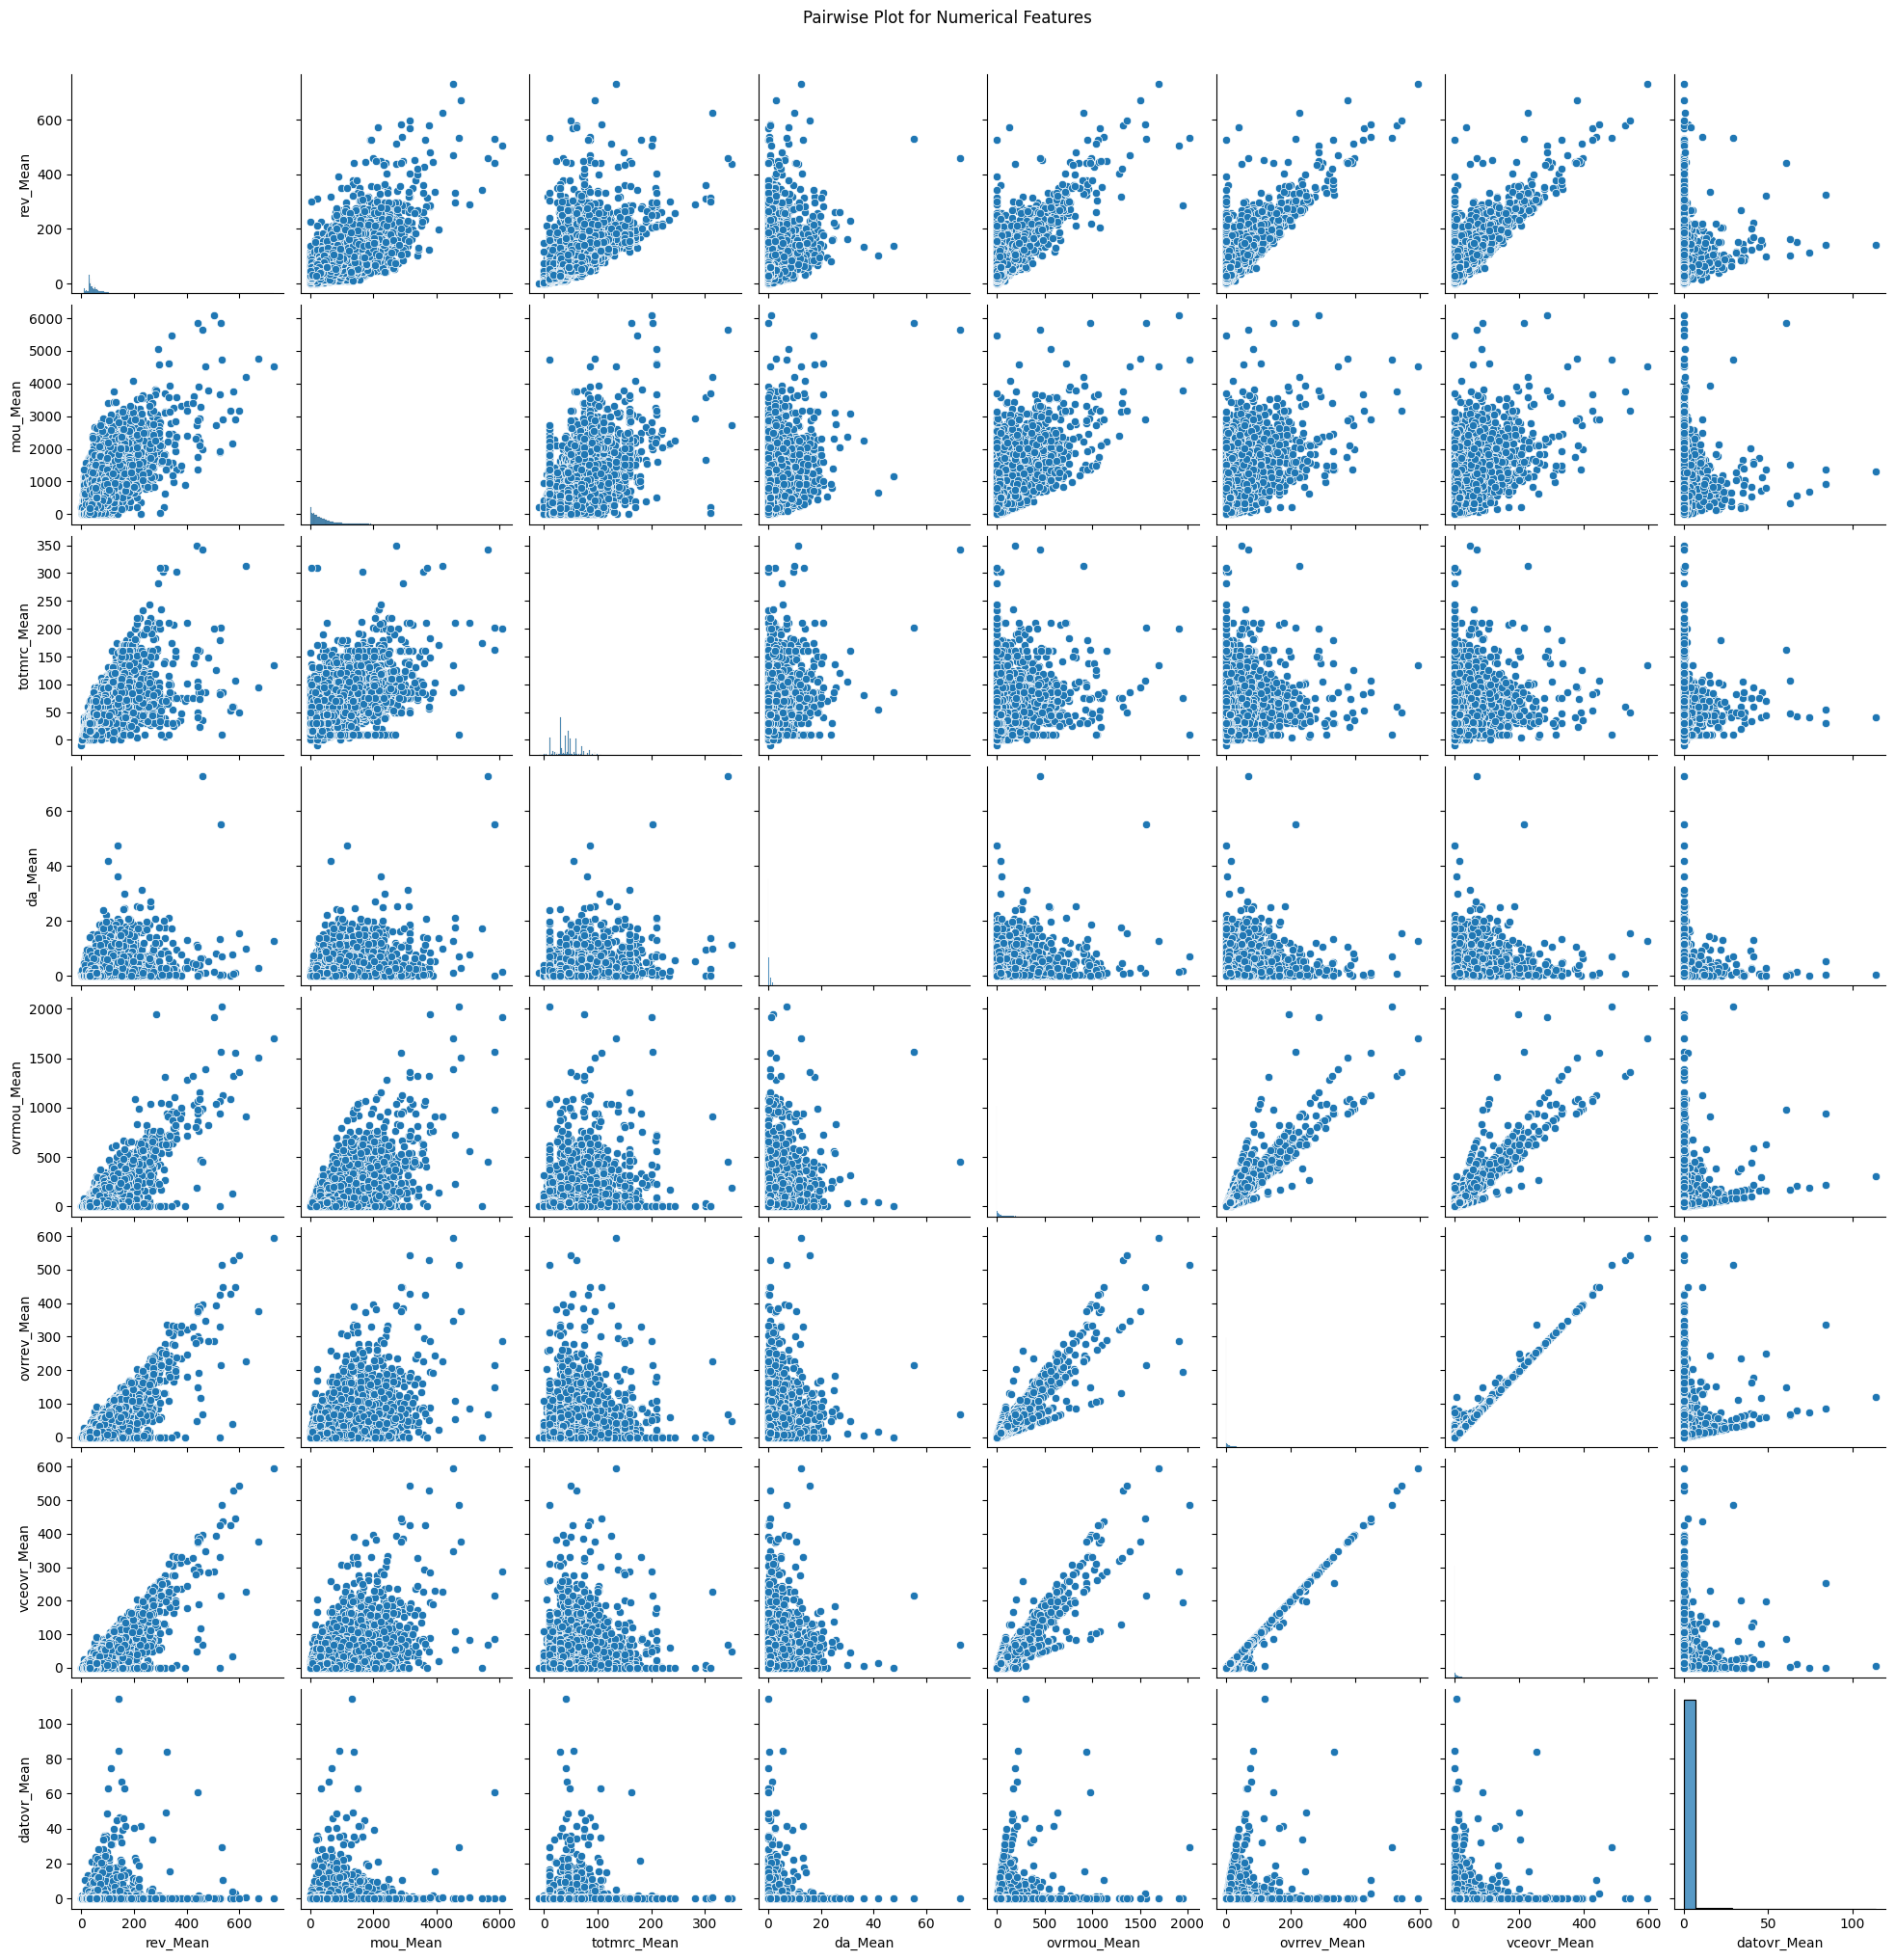

In [ ]:
#B. Pair Plots (Pairwise Relationships)
# Pairwise plot for numerical columns to identify relationships between pairs of features
sns.pairplot(df_pandas[numeric_columns])
plt.suptitle("Pairwise Plot for Numerical Features", y=1.02)
plt.show()

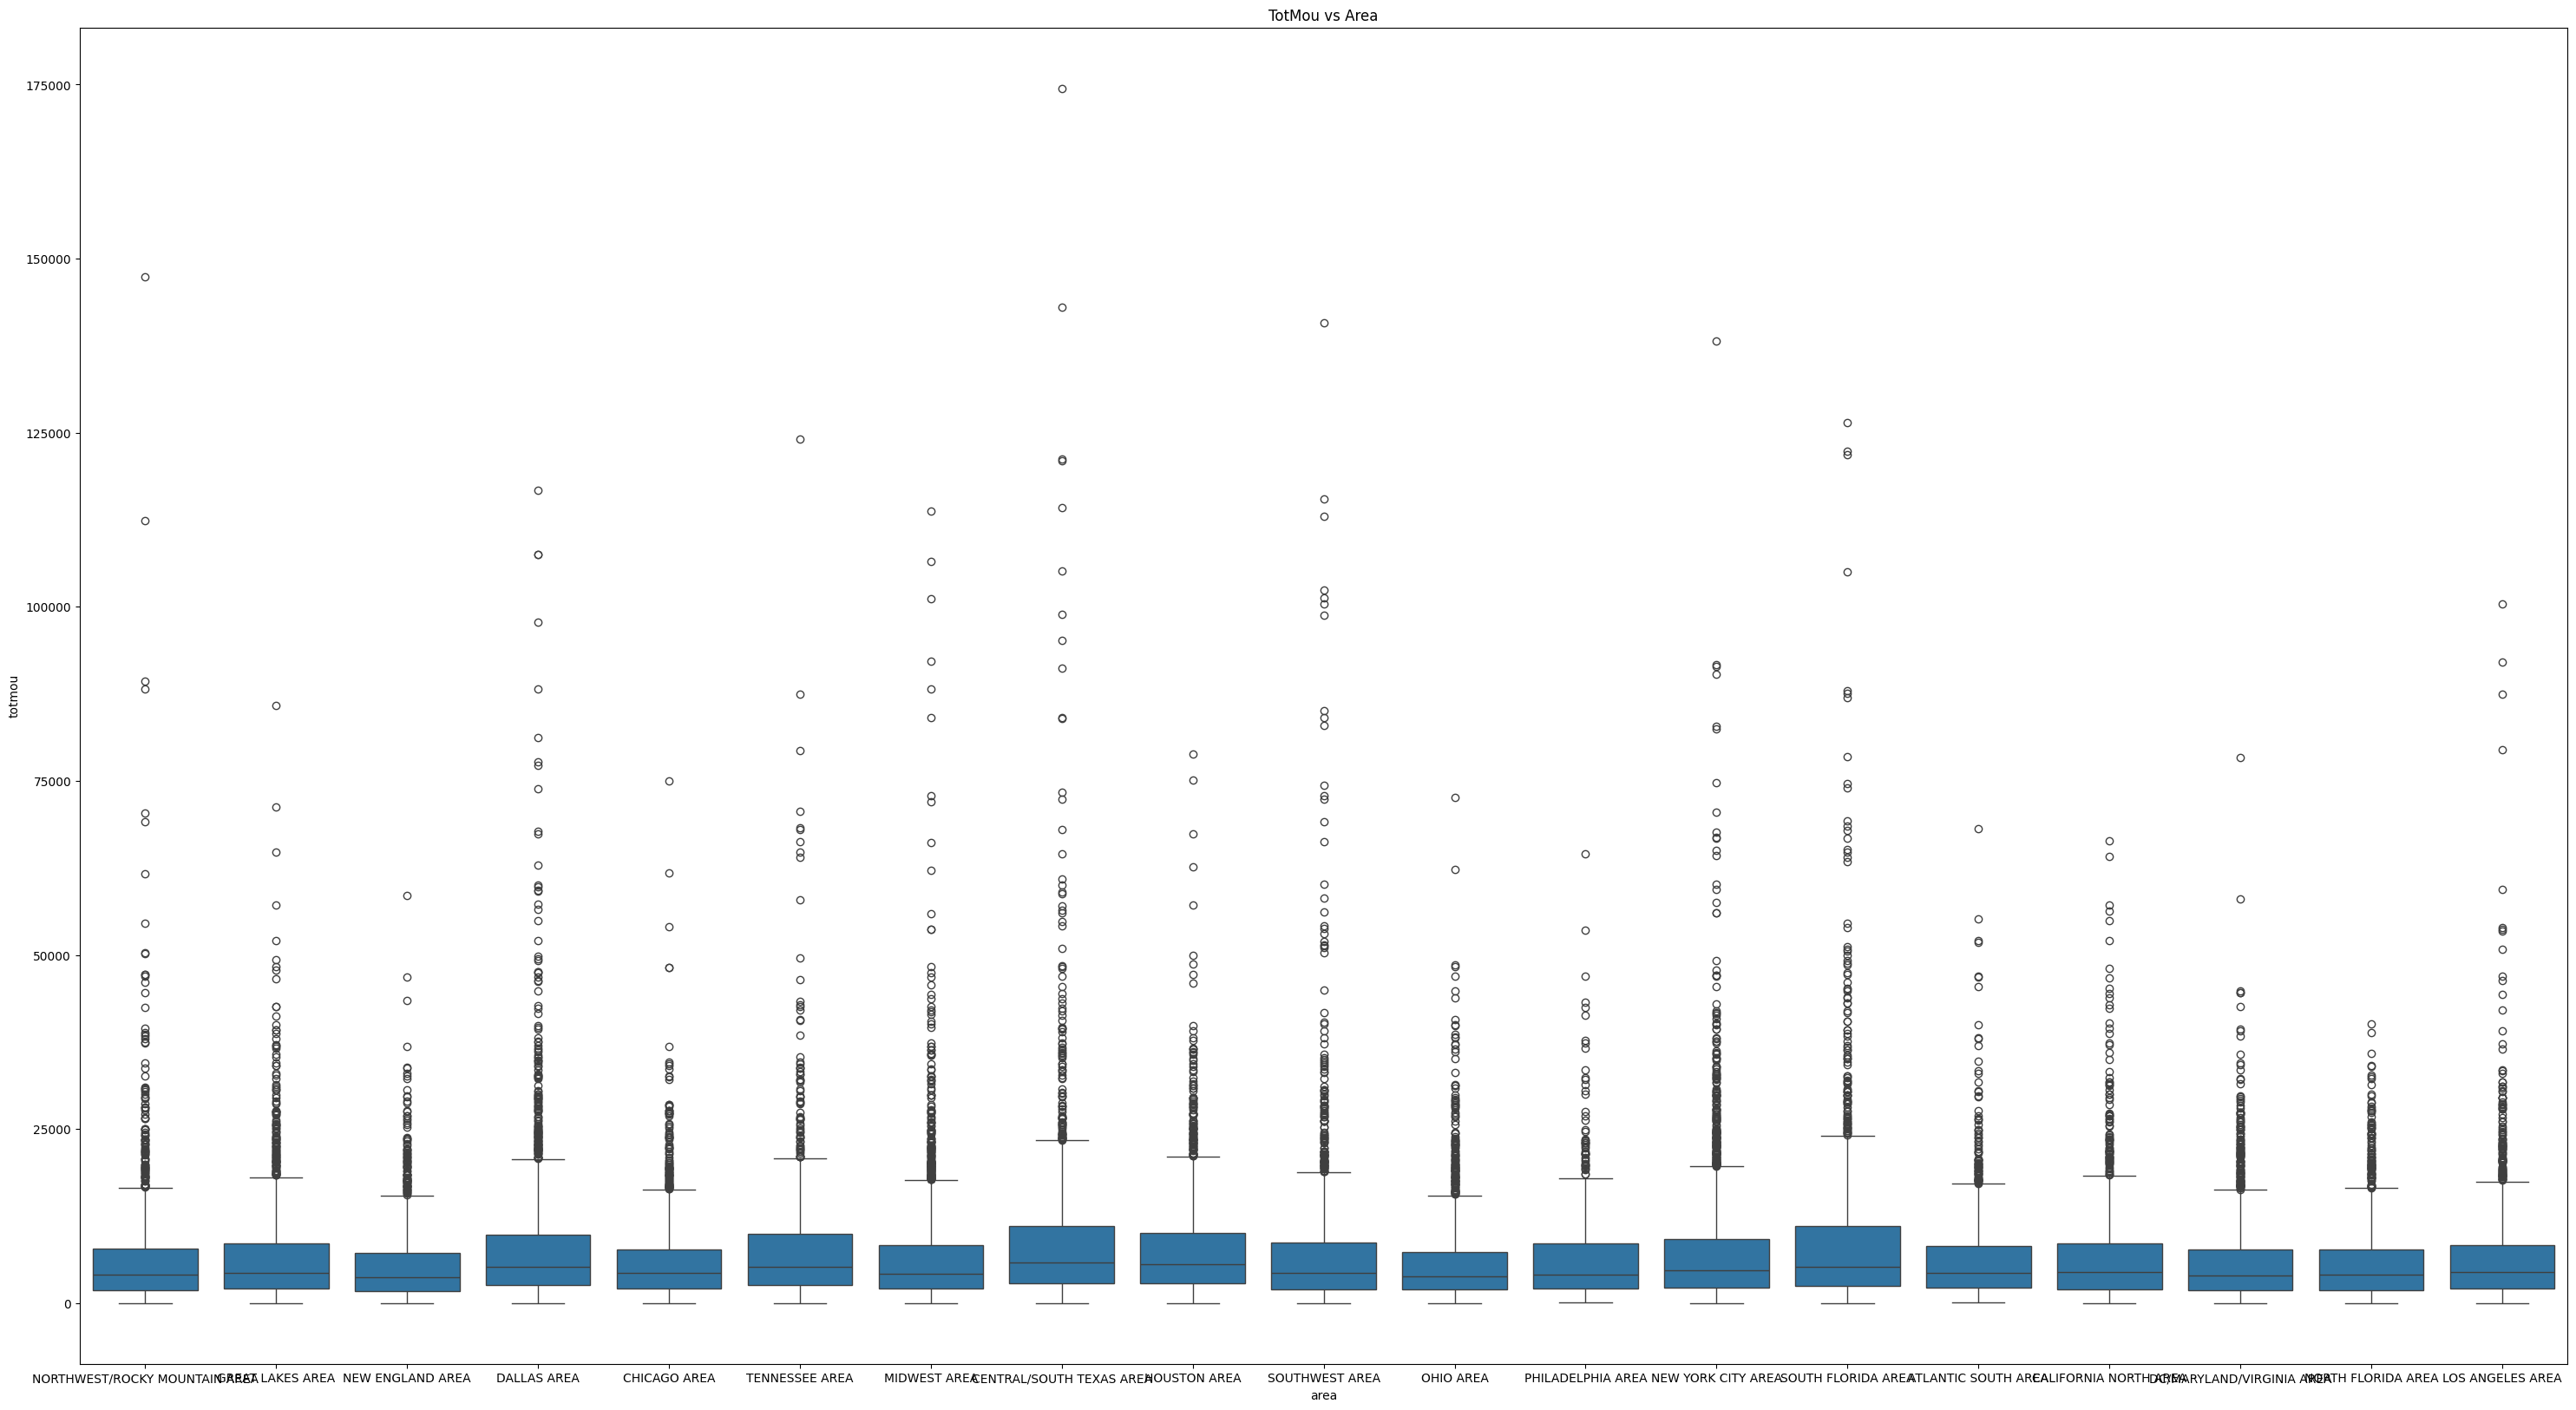

In [ ]:
#C. Categorical vs Numerical
# Violin plots or boxplots to see the distribution of numerical features against categorical features
plt.figure(figsize=(37, 20))

# Example: 'area' (categorical) vs 'totmou' (numerical)
sns.boxplot(data=df_pandas, x='area', y='totmou')
plt.title("TotMou vs Area")
plt.show()

# Repeat similar plots for other categorical columns


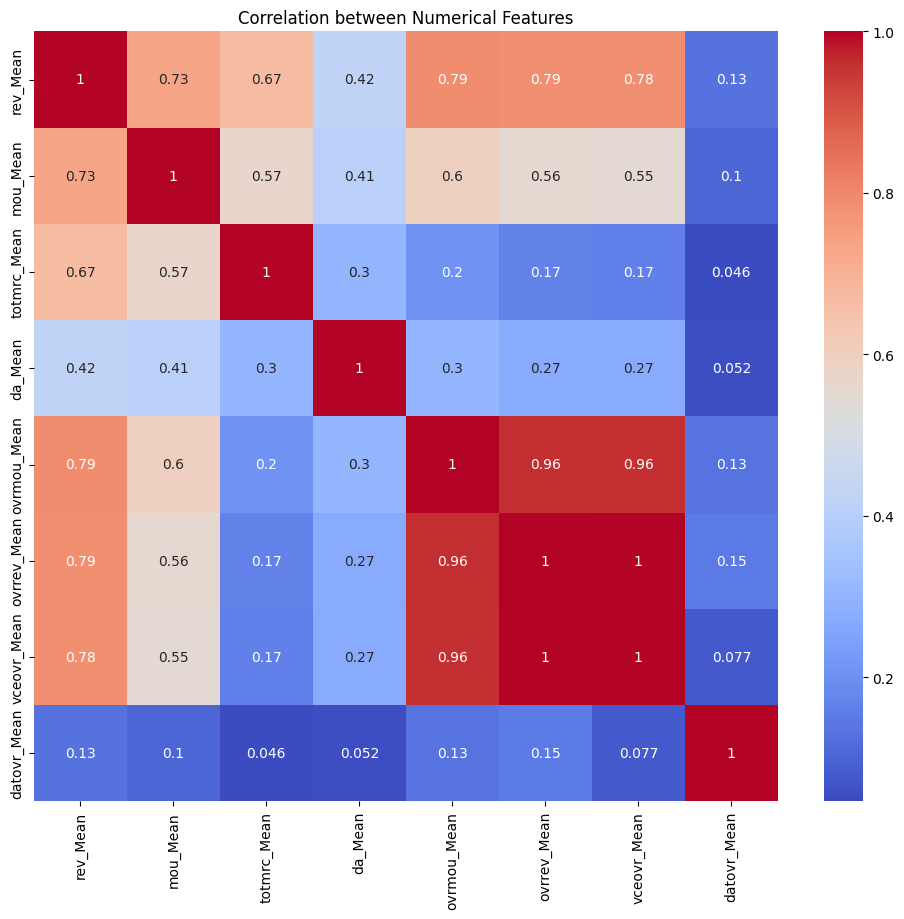

In [ ]:
# Heatmap for categorical vs numerical variables
plt.figure(figsize=(12, 10))
sns.heatmap(df_pandas[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Numerical Features")
plt.show()


**Top Spending Customer**

+-----------+-------------+
|Customer_ID|total_revenue|
+-----------+-------------+
|    1000630|     15023.95|
|    1000817|      13426.6|
|    1097931|     13358.37|
|    1001662|     13316.81|
|    1000318|     12719.22|
|    1001077|     11818.68|
|    1000570|     11529.73|
|    1000741|     11324.68|
|    1001297|     11205.59|
|    1000837|     10905.76|
+-----------+-------------+



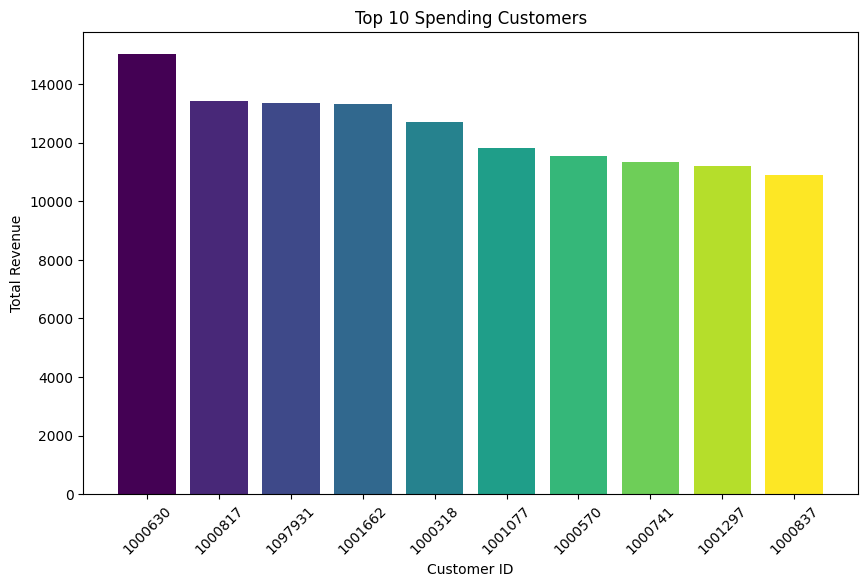

In [ ]:
# Remove duplicates and aggregate the revenue for each customer
top_spending_customers = df_cleaned.groupBy("Customer_ID").agg(F.sum("totrev").alias("total_revenue")) \
                                   .orderBy("total_revenue", ascending=False).limit(10)

top_spending_customers.show()

# Convert to Pandas for visualization
top_spending_customers_pd = top_spending_customers.toPandas()

# Visualization of Top Spending Customers
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(top_spending_customers_pd)))
plt.bar(top_spending_customers_pd['Customer_ID'].astype(str), top_spending_customers_pd['total_revenue'], color=colors)
plt.title('Top 10 Spending Customers')
plt.xlabel('Customer ID')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()


**Most frequently calling customers**

In [ ]:

# Most frequently calling customers based on total calls
most_frequent_callers = df_cleaned.orderBy(df_cleaned["totcalls"], ascending=False).select("Customer_ID", "totcalls").limit(10)
most_frequent_callers.show()


+-----------+--------+
|Customer_ID|totcalls|
+-----------+--------+
|    1000247|   80295|
|    1000318|   77444|
|    1000220|   72085|
|    1000689|   70411|
|    1000553|   67034|
|    1000449|   66754|
|    1000315|   64778|
|    1000438|   64690|
|    1000741|   62711|
|    1001077|   61752|
+-----------+--------+



**Most frequently calling customer based on minutes of use**

In [ ]:
# Most frequently calling customers based on minutes of use
most_frequent_callers_mou = df_cleaned.orderBy(df_cleaned["mou_Mean"], ascending=False).select("Customer_ID", "mou_Mean").limit(10)
most_frequent_callers_mou.show()


+-----------+--------+
|Customer_ID|mou_Mean|
+-----------+--------+
|    1086259| 6103.75|
|    1000318| 5863.25|
|    1096084|  5855.0|
|    1063639| 5635.75|
|    1096202|  5460.0|
|    1001077|  5053.0|
|    1075078|  4773.5|
|    1099873|  4719.0|
|    1048690|  4606.5|
|    1069899|  4591.5|
+-----------+--------+



**Churn customer and correlation of churn with imp feature**

In [ ]:
# Find churned customers
churned_customers = df_cleaned.filter(df_cleaned["churn"] == 1)
churned_customers.show()

# Feature correlation with churn (example: total revenue, data usage, etc.)
churn_correlation = df_cleaned.select("totrev", "da_Mean", "totmou", "churn").stat.corr("totrev", "churn")
print(f"Correlation between total revenue and churn: {churn_correlation}")


+--------+--------+-----------+-------+-----------+-----------+-----------+-----------+---------+----------+----------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-----------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+-------------+-------------+-------------+-------------+------------+------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+-----+------+--------+--------+--------+--------+--------+--------+-----------+-------+-------+--------+------+------+-------+------+-------+-------+-------+-------+-------+-------+----------------+--------------------+--------+----------+-----------+------+------+----------+-----+---+-------+---+--------+-------+------+--------+------+--------+--------+----

**High Revenue, Low Usage**

In [ ]:
#High Revenue, Low Usage (Opportunity for Upsell)
# Calculate 75th and 25th percentiles for 'totrev' and 'totmou'
totrev_75th = df_cleaned.approxQuantile("totrev", [0.75], 0.0)[0]
totmou_25th = df_cleaned.approxQuantile("totmou", [0.25], 0.0)[0]

# High revenue but low usage customers
high_revenue_low_usage = df_cleaned.filter(
    (df_cleaned["totrev"] > totrev_75th) & (df_cleaned["totmou"] < totmou_25th)
)

high_revenue_low_usage.show()


+--------+--------+-----------+-------+-----------+-----------+-----------+-----------+---------+----------+----------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-----------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+-------------+-------------+-------------+-------------+------------+------------+-------------+-------------+-------------+------------+-------------+-------------+-------------+-----+------+--------+--------+--------+--------+--------+--------+-------+-------+-------+-------+------+------+------+------+-------+-------+-------+-------+-------+-------+----------------+------------------+--------+----------+-----------+------+------+----------+-----+---+-------+---+--------+-------+------+--------+------+--------+--------+--------+---

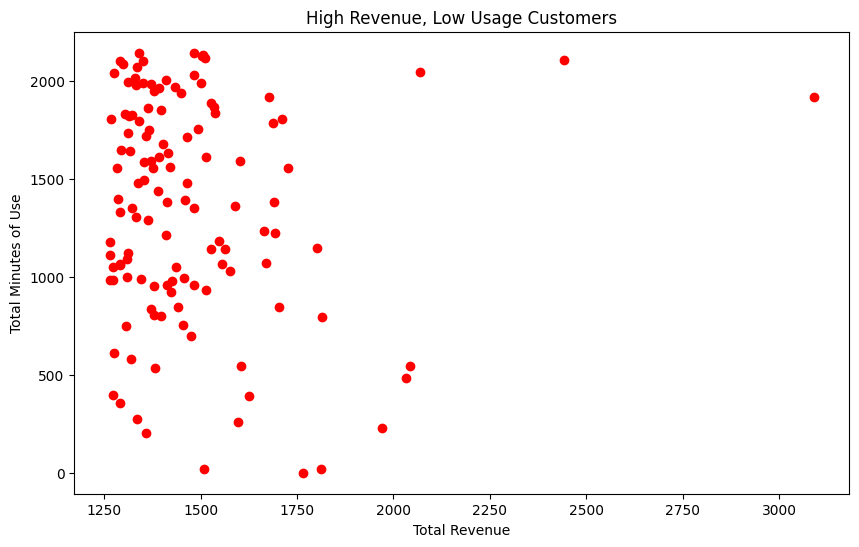

In [ ]:
# Convert Spark DataFrame to Pandas for plotting
high_revenue_low_usage_pd = high_revenue_low_usage.toPandas()

# Scatter plot to show high revenue, low usage customers
plt.figure(figsize=(10, 6))
plt.scatter(high_revenue_low_usage_pd['totrev'], high_revenue_low_usage_pd['totmou'], color='red')
plt.title('High Revenue, Low Usage Customers')
plt.xlabel('Total Revenue')
plt.ylabel('Total Minutes of Use')
plt.show()


**Customer segmentation based on usage **

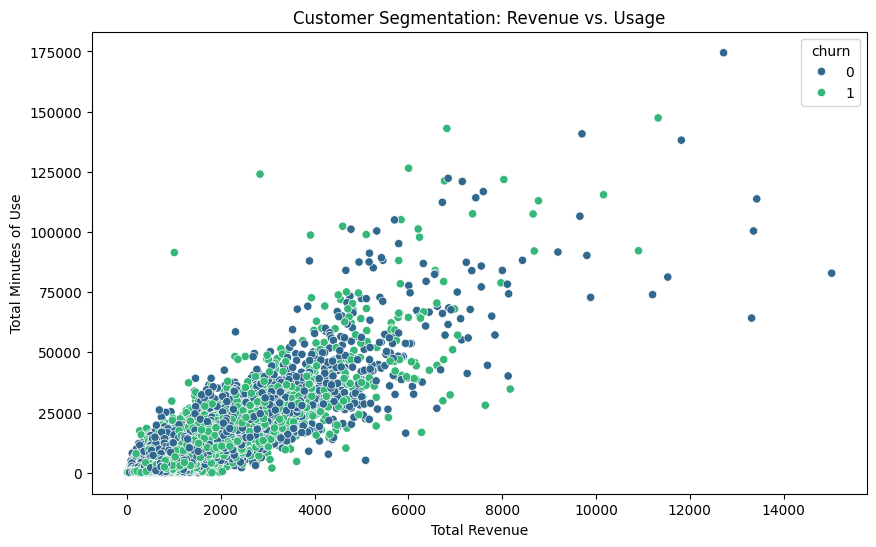

In [ ]:
#Customer Segmentation Based on Usage
#This will segment the customers into high, medium, and low revenue and usage categories.
# Calculate quantiles for segmentation
rev_quantiles = df_cleaned.approxQuantile("totrev", [0.33, 0.66], 0.0)
usage_quantiles = df_cleaned.approxQuantile("totmou", [0.33, 0.66], 0.0)

# Segment customers into high, medium, low based on revenue and usage
high_revenue = df_cleaned.filter(df_cleaned["totrev"] > rev_quantiles[1])
medium_revenue = df_cleaned.filter((df_cleaned["totrev"] > rev_quantiles[0]) & (df_cleaned["totrev"] <= rev_quantiles[1]))
low_revenue = df_cleaned.filter(df_cleaned["totrev"] <= rev_quantiles[0])

high_usage = df_cleaned.filter(df_cleaned["totmou"] > usage_quantiles[1])
medium_usage = df_cleaned.filter((df_cleaned["totmou"] > usage_quantiles[0]) & (df_cleaned["totmou"] <= usage_quantiles[1]))
low_usage = df_cleaned.filter(df_cleaned["totmou"] <= usage_quantiles[0])

# Visualize Revenue vs Usage Segmentation
plt.figure(figsize=(10, 6))
sns.scatterplot(x="totrev", y="totmou", data=df_cleaned.toPandas(), hue="churn", palette="viridis")
plt.title('Customer Segmentation: Revenue vs. Usage')
plt.xlabel('Total Revenue')
plt.ylabel('Total Minutes of Use')
plt.show()



**Visualizing high usage and low usage customers**

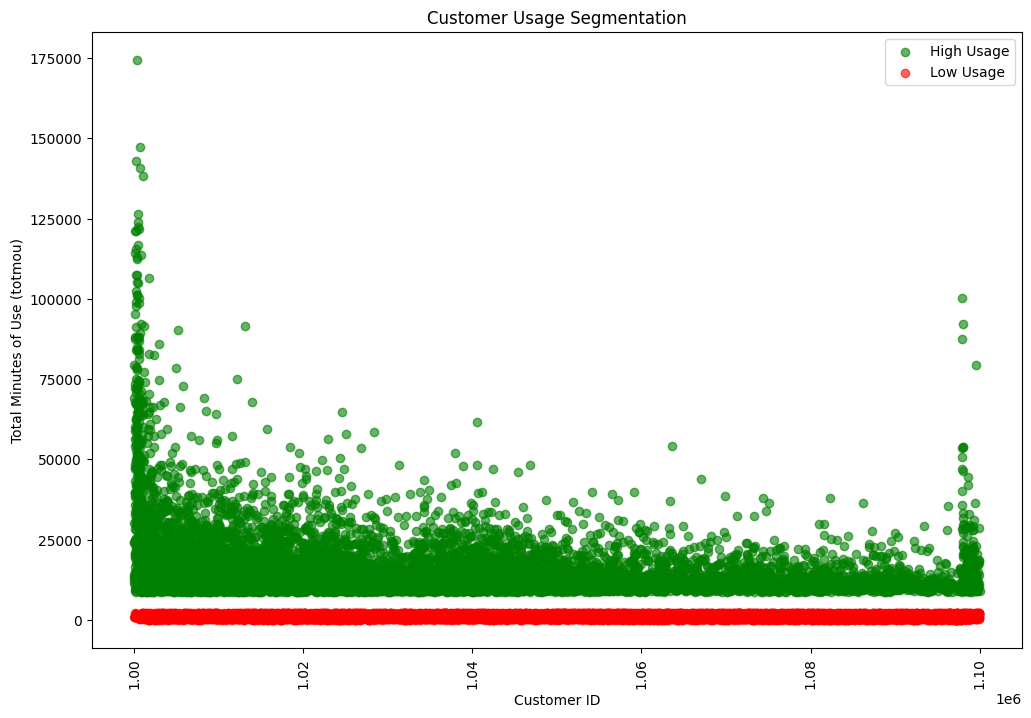

In [ ]:
#visualize high and low usage customers:
# Convert Spark DataFrame to Pandas for plotting
high_usage_pd = high_usage.toPandas()
low_usage_pd = low_usage.toPandas()

# Set up the plot
plt.figure(figsize=(12, 8))

# Plot high usage customers
plt.scatter(high_usage_pd["Customer_ID"], high_usage_pd["totmou"], color='green', label='High Usage', alpha=0.6)

# Plot low usage customers
plt.scatter(low_usage_pd["Customer_ID"], low_usage_pd["totmou"], color='red', label='Low Usage', alpha=0.6)

# Add labels and title
plt.title('Customer Usage Segmentation')
plt.xlabel('Customer ID')
plt.ylabel('Total Minutes of Use (totmou)')

# Rotate x-axis labels if necessary
plt.xticks(rotation=90)

# Add legend
plt.legend()

# Show the plot
plt.show()

**Churn vs revenue/usage**

+-----------+-------+-----------+
|Customer_ID| totrev|     totmou|
+-----------+-------+-----------+
|    1000001|1504.62|     4228.0|
|    1000003|2155.91|24385.05333|
|    1000021| 6751.7|79406.01667|
|    1000027|3513.41|   30020.16|
|    1000038|1006.81|     3109.0|
|    1000040|1591.01|5970.016667|
|    1000045|2382.62|     8471.0|
|    1000047| 1555.0|     4672.0|
|    1000048|3187.88|    32772.0|
|    1000049|1803.31|     9615.0|
|    1000051|2870.33|   19818.04|
|    1000055|2399.93|     7942.0|
|    1000057| 3836.3|    35711.0|
|    1000059|2415.79|    8925.07|
|    1000069|2130.37|    13075.0|
|    1000070|2762.23|24958.11333|
|    1000072|2954.67|16488.01667|
|    1000079|1458.92|     2184.0|
|    1000090|1402.64|     4909.0|
|    1000110|4811.88|   67742.45|
+-----------+-------+-----------+
only showing top 20 rows



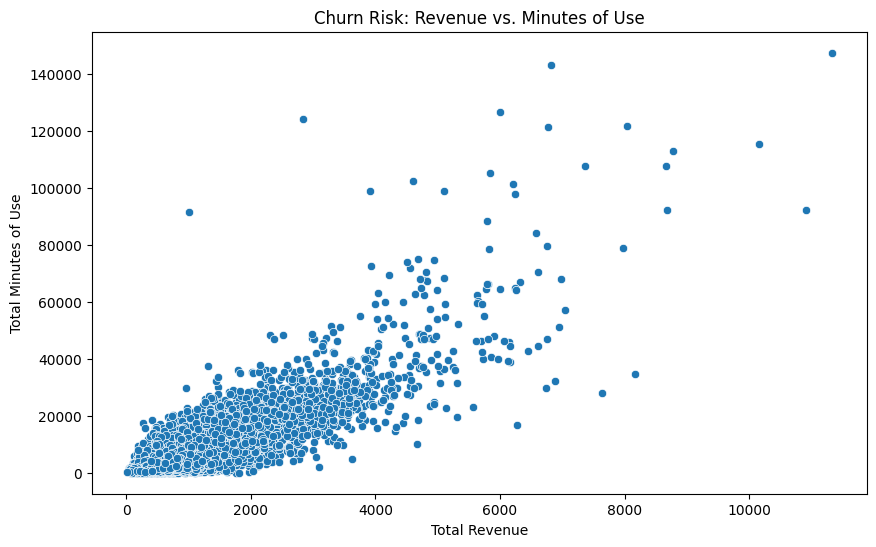

In [ ]:
#Churn Risk Prediction (Churn vs Usage/Revenue)
#Analyzing features to identify churn risk using historical usage and revenue data.
# Churn vs Revenue/Usage
churn_risk = df_cleaned.filter(df_cleaned["churn"] == 1)

# Show churn risk customers
churn_risk.select("Customer_ID", "totrev", "totmou").show()

# Visualize Churn vs Revenue/Usage
churn_risk_pd = churn_risk.toPandas()
plt.figure(figsize=(10, 6))
sns.scatterplot(x="totrev", y="totmou", data=churn_risk_pd)
plt.title('Churn Risk: Revenue vs. Minutes of Use')
plt.xlabel('Total Revenue')
plt.ylabel('Total Minutes of Use')
plt.show()



**High data usage customer**

+-----------+-------+
|Customer_ID|da_Mean|
+-----------+-------+
|    1000015| 2.2275|
|    1000027|  1.485|
|    1000066|   0.99|
|    1000076|   2.97|
|    1000086|  1.485|
|    1000102| 1.7325|
|    1000110|  1.485|
|    1000114|  1.485|
|    1000115|   1.98|
|    1000119|   0.99|
|    1000124| 3.2175|
|    1000128|  8.415|
|    1000129| 3.7125|
|    1000137| 3.7125|
|    1000159|   4.95|
|    1000168| 4.2075|
|    1000174| 4.2075|
|    1000176|   4.95|
|    1000179| 1.7325|
|    1000182| 7.6725|
+-----------+-------+
only showing top 20 rows



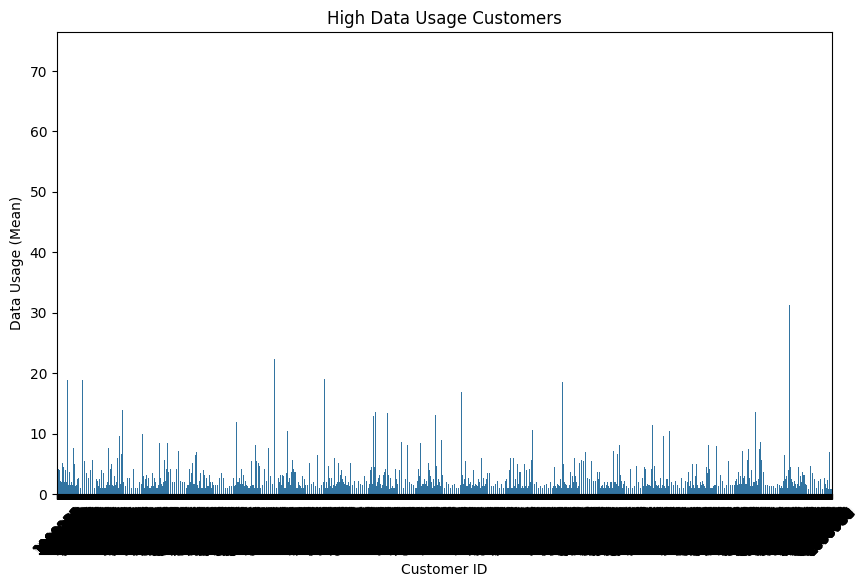

In [ ]:

# High data usage customers
#This analysis will identify customers with high data usage and possibly require network optimization or data plan adjustments.
high_data_usage = df_cleaned.filter(df_cleaned["da_Mean"] > df_cleaned.approxQuantile("da_Mean", [0.75], 0.0)[0])

# Show high data usage customers
high_data_usage.select("Customer_ID", "da_Mean").show()

# Visualize High Data Usage Customers
high_data_usage_pd = high_data_usage.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x="Customer_ID", y="da_Mean", data=high_data_usage_pd)
plt.title('High Data Usage Customers')
plt.xlabel('Customer ID')
plt.ylabel('Data Usage (Mean)')
plt.xticks(rotation=45)
plt.show()


**Network congestion prediction**

+-----------+-------------+-------------+
|Customer_ID|peak_vce_Mean|peak_dat_Mean|
+-----------+-------------+-------------+
|    1000128|  1101.333333|          1.0|
|    1000179|  1158.666667|          0.0|
|    1000318|  1355.666667|  0.333333333|
|    1000741|  1439.333333|          0.0|
|    1001012|  1018.666667|          0.0|
|    1001077|  1096.333333|  13.66666667|
|    1005193|  1138.666667|          0.0|
|    1011560|       1271.0|          0.0|
|    1028321|  1323.333333|  0.333333333|
|    1040524|  1222.666667|          0.0|
|    1043617|  1070.666667|          0.0|
|    1045377|  1119.333333|          0.0|
|    1048690|       1257.0|          0.0|
|    1059122|       1130.0|          0.0|
|    1063639|  1474.666667|          0.0|
|    1068059|  1117.666667|          0.0|
|    1069899|  1165.666667|          0.0|
|    1073216|       1292.0|          0.0|
|    1086259|  1784.666667|  0.333333333|
|    1093468|  1008.333333|          0.0|
+-----------+-------------+-------

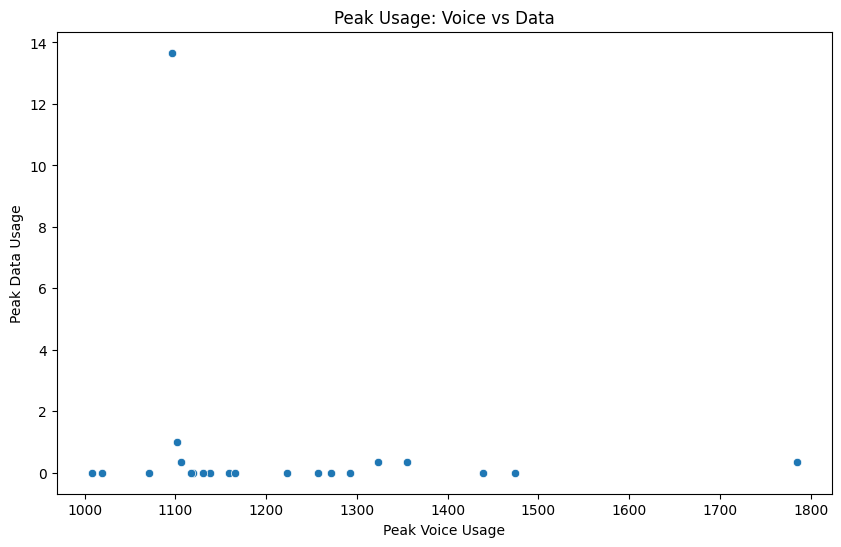

In [ ]:
#Network Congestion Prediction
#This analysis looks at peak usage periods based on features like peak_vce_Mean and peak_dat_Mean.
# Peak usage analysis for network congestion prediction
peak_usage = df_cleaned.filter((df_cleaned["peak_vce_Mean"] > 1000) | (df_cleaned["peak_dat_Mean"] > 1000))

# Show peak usage customers
peak_usage.select("Customer_ID", "peak_vce_Mean", "peak_dat_Mean").show()

# Visualize Peak Usage for Congestion Prediction
peak_usage_pd = peak_usage.toPandas()
plt.figure(figsize=(10, 6))
sns.scatterplot(x="peak_vce_Mean", y="peak_dat_Mean", data=peak_usage_pd)
plt.title('Peak Usage: Voice vs Data')
plt.xlabel('Peak Voice Usage')
plt.ylabel('Peak Data Usage')
plt.show()


**Customer satisfaction and service issue**

+-----------+-------------+-------------+
|Customer_ID|custcare_Mean|blck_vce_Mean|
+-----------+-------------+-------------+
|    1000005|  8.666666667|  0.666666667|
|    1000017|  3.666666667|          0.0|
|    1000019|  4.333333333|          6.0|
|    1000021|  0.333333333|         18.0|
|    1000048|          1.0|  6.333333333|
|    1000076|  9.666666667|  1.333333333|
|    1000084|  3.666666667|          1.0|
|    1000085|          0.0|  7.333333333|
|    1000086|          0.0|         11.0|
|    1000092|  3.333333333|          7.0|
|    1000095|  6.666666667|         11.0|
|    1000099|          3.0|  7.333333333|
|    1000102|          0.0|  5.333333333|
|    1000110|  9.333333333|  9.666666667|
|    1000115|          0.0|         19.0|
|    1000119|  0.333333333|  10.33333333|
|    1000124|          0.0|  13.33333333|
|    1000127|          0.0|  10.33333333|
|    1000128|  0.666666667|  19.33333333|
|    1000129|  0.666666667|  18.33333333|
+-----------+-------------+-------

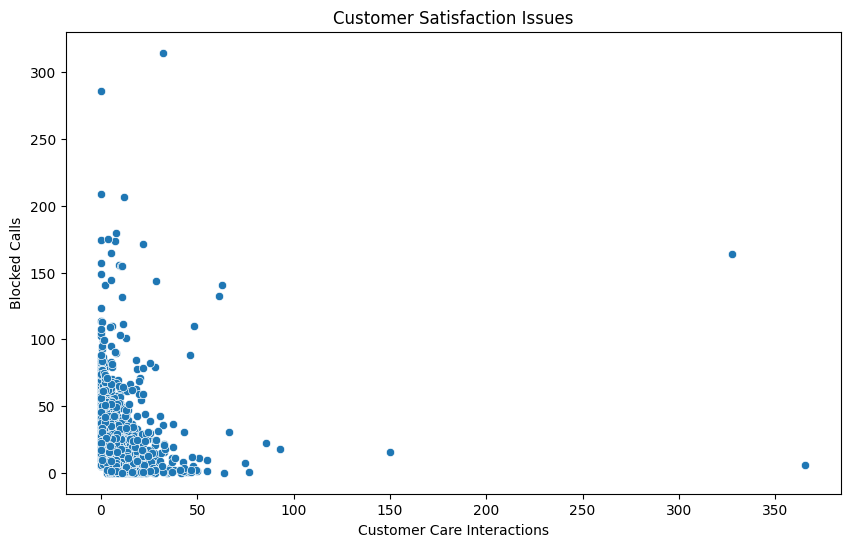

In [ ]:
#Customer Satisfaction and Service Issues
#This analysis highlights customers with frequent service issues using the custcare_Mean and blck_vce_Mean.
# Identify customers with service issues
service_issues = df_cleaned.filter((df_cleaned["custcare_Mean"] > 3) | (df_cleaned["blck_vce_Mean"] > 5))

# Show customers with service issues
service_issues.select("Customer_ID", "custcare_Mean", "blck_vce_Mean").show()

# Visualize Customers with Service Issues
service_issues_pd = service_issues.toPandas()
plt.figure(figsize=(10, 6))
sns.scatterplot(x="custcare_Mean", y="blck_vce_Mean", data=service_issues_pd)
plt.title('Customer Satisfaction Issues')
plt.xlabel('Customer Care Interactions')
plt.ylabel('Blocked Calls')
plt.show()


**Customer demographics and revenue usage**

+-----------+------+-------+------+-------+
|Customer_ID|income|marital|ethnic| totrev|
+-----------+------+-------+------+-------+
|    1000001|     4|      S|     N|1504.62|
|    1000003|     5|      M|     N|2155.91|
|    1000005|     6|      S|     I|2181.12|
|    1000008|     1|      M|     S|1427.71|
|    1000010|     9|      M|     N|1458.42|
|    1000015|     3|      S|     N|6616.72|
|    1000017|     3|      U|     N|1739.43|
|    1000019|     3|      B|     N|1935.97|
|    1000020|     1|      S|     S|1348.33|
|    1000021|     6|      U|     Z| 6751.7|
|    1000027|     9|      M|     N|3513.41|
|    1000037|     9|      M|     N|1518.34|
|    1000038|     7|      M|     N|1006.81|
|    1000040|     9|      M|     J|1591.01|
|    1000041|     8|      M|     N|2741.17|
|    1000045|     6|      M|     N|2382.62|
|    1000047|     5|      M|     N| 1555.0|
|    1000048|     5|      M|     H|3187.88|
|    1000049|     7|      M|     N|1803.31|
|    1000051|     3|      M|    

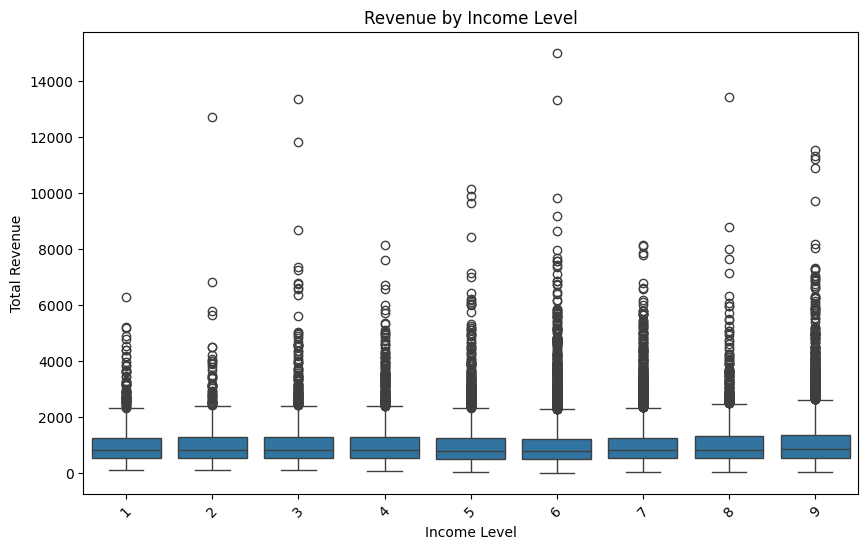

In [ ]:
#Customer Demographics and Revenue Insights
#This analysis will look at how demographic features like income, marital, and ethnic impact revenue.
# Customer demographics and revenue analysis
demographic_revenue = df_cleaned.select("Customer_ID", "income", "marital", "ethnic", "totrev")

# Show demographic and revenue data
demographic_revenue.show()

# Visualize Revenue by Income Level
plt.figure(figsize=(10, 6))
sns.boxplot(x="income", y="totrev", data=demographic_revenue.toPandas())
plt.title('Revenue by Income Level')
plt.xlabel('Income Level')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()


**Analysis of customer activity over time**

+------+------------------+
|months|       avg(totmou)|
+------+------------------+
|     6| 2786.674267100977|
|     7| 2887.620720720721|
|     8|3543.9916142557654|
|     9|3658.7510373443984|
|    10| 4127.617433414043|
|    11|4580.3415346121765|
|    12| 4810.957371225577|
|    13|  5269.51849568434|
|    14| 5425.318043972707|
|    15|5870.0695187165775|
|    16| 6085.797585886722|
|    17| 6212.590056285178|
|    18| 6492.070729053319|
|    19| 6018.672883787662|
|    20| 7309.862631578947|
|    21| 6660.480076628352|
|    22| 7047.378555798687|
|    23| 6848.633285302593|
|    24| 7341.012571428571|
|    25| 7081.277334397446|
+------+------------------+
only showing top 20 rows



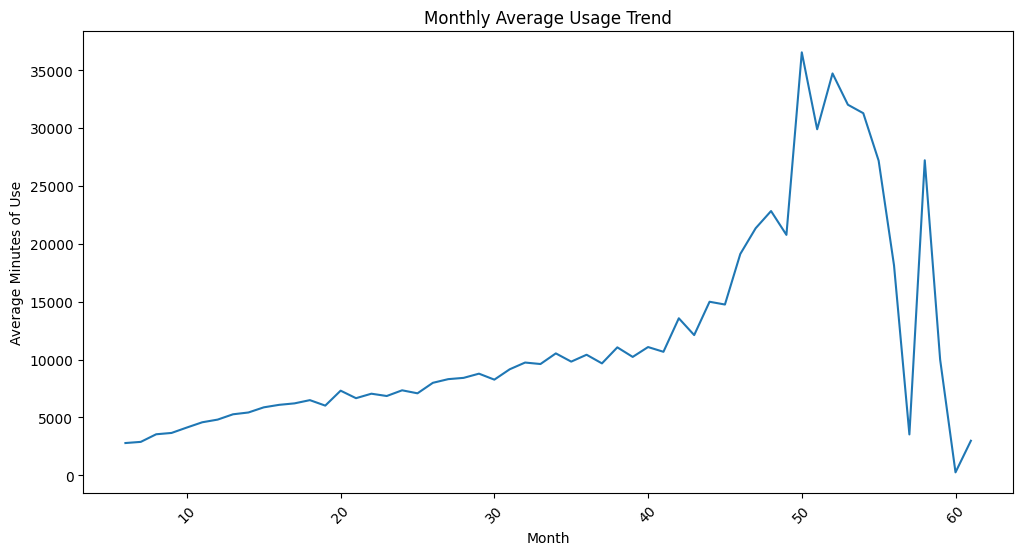

In [ ]:
#Analysis of Customer Activity Over Time (Time Series)
#By analyzing usage trends over time (using months, avg3mou, avg6mou) we observe any significant changes in customer behavior, which could be linked to network congestion, promotions, or service issues.
#Trend of monthly usage Understanding customer activity over time can highlight seasonal trends, promotions' effectiveness, and network demand patterns.

monthly_usage = df_cleaned.groupBy("months").agg({"totmou": "mean"}).orderBy("months")

# Show monthly usage trend
monthly_usage.show()

# Visualize Monthly Usage Trend
monthly_usage_pd = monthly_usage.toPandas()
plt.figure(figsize=(12, 6))
sns.lineplot(x="months", y="avg(totmou)", data=monthly_usage_pd)
plt.title('Monthly Average Usage Trend')
plt.xlabel('Month')
plt.ylabel('Average Minutes of Use')
plt.xticks(rotation=45)
plt.show()


**Device and model analysis**

+------+------------------+
|models|       avg(totrev)|
+------+------------------+
|     9| 4693.084000000001|
|     8|3895.6786666666662|
|    10|          3889.915|
|     7|3279.6987878787877|
|     6| 3201.116792452829|
|     5| 2783.891807692309|
|    11|           2719.05|
|     4| 2210.632801047121|
|     3|1667.1889230155582|
|     2|1223.2968436137048|
|     1|  786.843129691211|
+------+------------------+



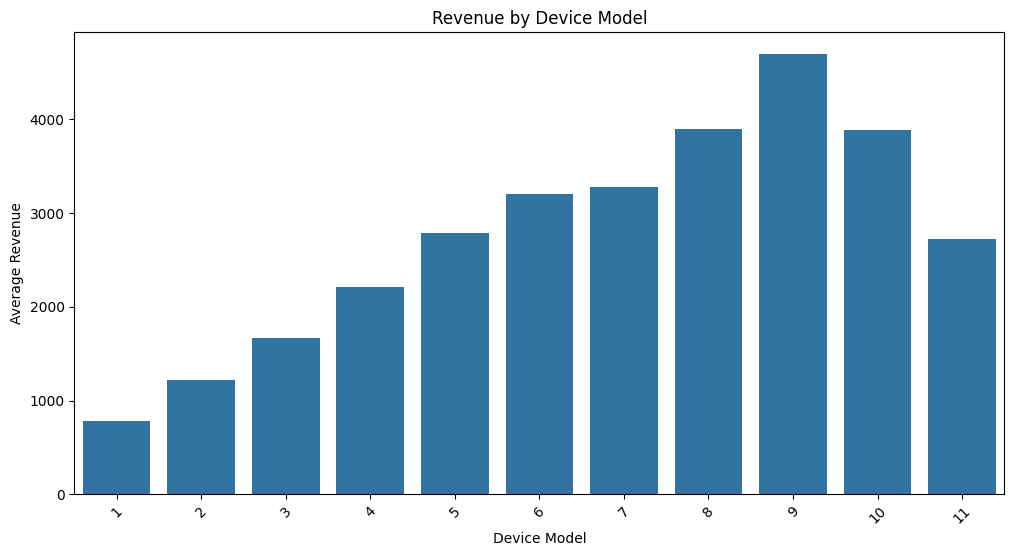

In [ ]:
#Device/Model Analysis
#Analyzing which devices or models (e.g., models, hnd_price) are associated with higher revenue or usage can help optimize marketing strategies or understand customer preferences.
# Device and revenue analysis
device_revenue = df_cleaned.groupBy("models").agg({"totrev": "mean"}).orderBy("avg(totrev)", ascending=False)

# Show revenue by device
device_revenue.show()

# Visualize Revenue by Device/Model
device_revenue_pd = device_revenue.toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(x="models", y="avg(totrev)", data=device_revenue_pd)
plt.title('Revenue by Device Model')
plt.xlabel('Device Model')
plt.ylabel('Average Revenue')
plt.xticks(rotation=45)
plt.show()


**Network usage and romaming pattern**

+-----------+---------+-----------+-------+
|Customer_ID|roam_Mean|     totmou| totrev|
+-----------+---------+-----------+-------+
|    1000001|      0.0|     4228.0|1504.62|
|    1000003|      0.0|24385.05333|2155.91|
|    1000005|      0.0|    14028.0|2181.12|
|    1000008|      0.0|    12492.0|1427.71|
|    1000010|      0.0|      994.0|1458.42|
|    1000015|  35.4975|69161.08333|6616.72|
|    1000017|   1.3125|    11330.0|1739.43|
|    1000019|    1.285|    23835.0|1935.97|
|    1000020|      0.0|4531.016667|1348.33|
|    1000021|      0.0|79406.01667| 6751.7|
|    1000027|      0.0|   30020.16|3513.41|
|    1000037|      0.0|     3827.0|1518.34|
|    1000038|      0.0|     3109.0|1006.81|
|    1000040|    2.565|5970.016667|1591.01|
|    1000041|   1.9375|    13430.0|2741.17|
|    1000045|      0.0|     8471.0|2382.62|
|    1000047|      0.0|     4672.0| 1555.0|
|    1000048|      0.0|    32772.0|3187.88|
|    1000049|      0.0|     9615.0|1803.31|
|    1000051|      0.0|   19818.

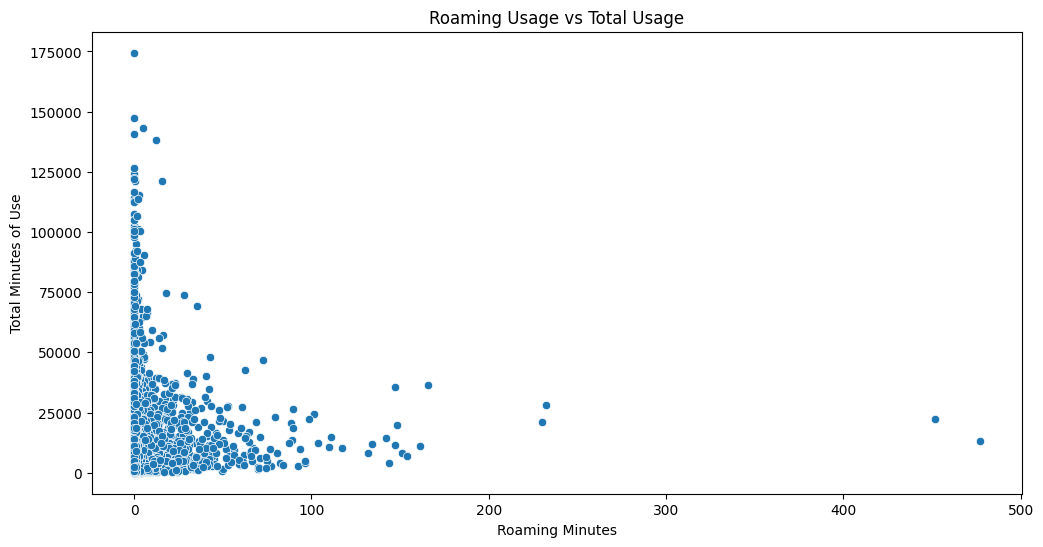

In [ ]:
#Network Usage and Roaming Patterns
#This analysis focuses on understanding how roaming behavior (e.g., roam_Mean, vceovr_Mean) affects customer experience and network congestion.
#This analysis helps identify how roaming usage impacts the overall network load and could provide insights into potential network optimizations or customer support actions.

# Roaming vs Total Usage
roaming_vs_usage = df_cleaned.select("Customer_ID", "roam_Mean", "totmou", "totrev")

# Show roaming vs usage
roaming_vs_usage.show()

# Visualize Roaming vs Usage
roaming_vs_usage_pd = roaming_vs_usage.toPandas()
plt.figure(figsize=(12, 6))
sns.scatterplot(x="roam_Mean", y="totmou", data=roaming_vs_usage_pd)
plt.title('Roaming Usage vs Total Usage')
plt.xlabel('Roaming Minutes')
plt.ylabel('Total Minutes of Use')
plt.show()



**Impact of customer demographics on churn**

+------+------+-------+-------------------+
|income|ethnic|marital|         avg(churn)|
+------+------+-------+-------------------+
|     6|     G|      M|0.42896174863387976|
|     8|     N|      U|               0.51|
|     9|     F|      U| 0.6363636363636364|
|     1|     N|      M| 0.5166666666666667|
|     1|     B|      S|                0.8|
|     9|     H|      M| 0.4891304347826087|
|     1|     F|      M|               0.75|
|     5|     D|      M|0.45454545454545453|
|     6|     J|      U| 0.5454545454545454|
|     7|     O|      M| 0.5849056603773585|
|     4|     S|      B| 0.5909090909090909|
|     6|     M|      M|                0.5|
|     3|     H|      S|0.49557522123893805|
|     9|     H|      B| 0.8571428571428571|
|     7|     Z|      S|0.21739130434782608|
|     3|     J|      M|                0.5|
|     3|     J|      A|                0.5|
|     3|     F|      B| 0.6666666666666666|
|     3|     N|      B| 0.4262295081967213|
|     8|     S|      M|  0.47849

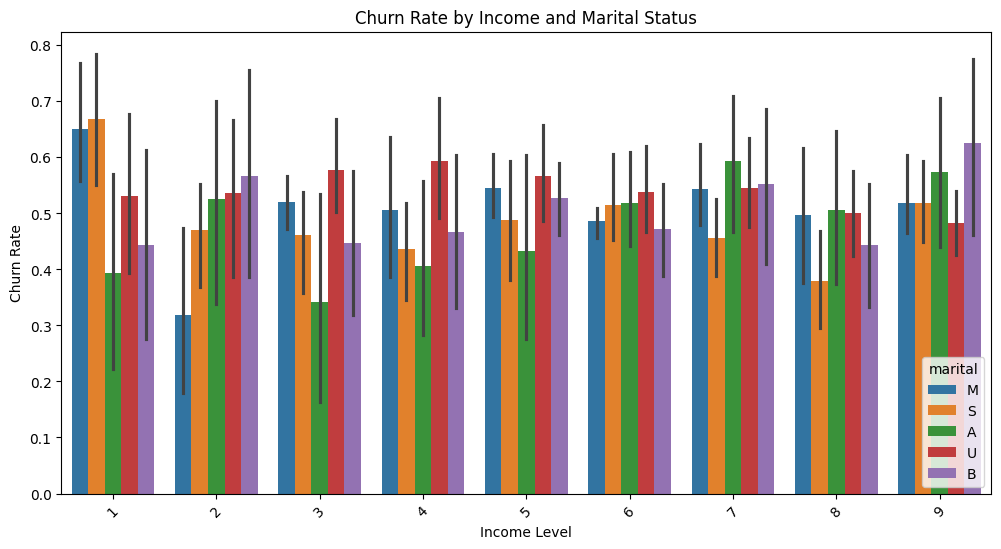

In [ ]:
#Impact of Customer Demographics on Churn
# analyze how customer demographics such as income, ethnic, marital status, and adults affect the likelihood of churn.
#Understanding how customer demographics influence churn can help create targeted retention strategies, such as tailored promotions.

# Churn based on customer demographics
churn_demographics = df_cleaned.groupBy("income", "ethnic", "marital").agg({"churn": "mean"})

# Show churn rates by demographics
churn_demographics.show()

# Visualize churn by income level and marital status
churn_demographics_pd = churn_demographics.toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(x="income", y="avg(churn)", hue="marital", data=churn_demographics_pd)
plt.title('Churn Rate by Income and Marital Status')
plt.xlabel('Income Level')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()


**Device and model analysis**

+------+------------------+
|models|       avg(totrev)|
+------+------------------+
|     9| 4693.084000000001|
|     8|3895.6786666666662|
|    10|          3889.915|
|     7|3279.6987878787877|
|     6| 3201.116792452829|
|     5| 2783.891807692309|
|    11|           2719.05|
|     4| 2210.632801047121|
|     3|1667.1889230155582|
|     2|1223.2968436137048|
|     1|  786.843129691211|
+------+------------------+



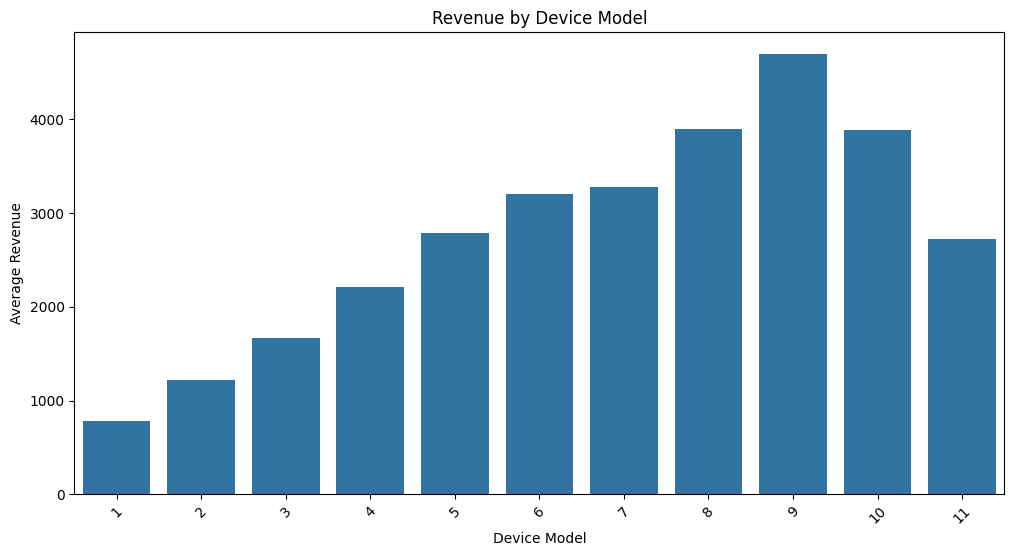

In [ ]:
#Device/Model Analysis
#Analyzing which devices or models (e.g., models, hnd_price) are associated with higher revenue or usage can help optimize marketing strategies or understand customer preferences.
# Device and revenue analysis
device_revenue = df_cleaned.groupBy("models").agg({"totrev": "mean"}).orderBy("avg(totrev)", ascending=False)

# Show revenue by device
device_revenue.show()

# Visualize Revenue by Device/Model
device_revenue_pd = device_revenue.toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(x="models", y="avg(totrev)", data=device_revenue_pd)
plt.title('Revenue by Device Model')
plt.xlabel('Device Model')
plt.ylabel('Average Revenue')
plt.xticks(rotation=45)
plt.show()


**Compare the performance of the Spark operations on three columns**

In [ ]:
# Measure execution time for 'totrev' aggregation
start_time = time.time()
df_cleaned.agg(F.sum('totrev')).show()
totrev_execution_time = time.time() - start_time

# Measure execution time for 'totmou' aggregation
start_time = time.time()
df_cleaned.agg(F.avg('totmou')).show()
totmou_execution_time = time.time() - start_time

# Measure execution time for 'churn' group count
start_time = time.time()
df_cleaned.groupBy('churn').count().show()
churn_execution_time = time.time() - start_time

# Print execution times
print(f"Execution time for 'totrev' aggregation: {totrev_execution_time} seconds")
print(f"Execution time for 'totmou' aggregation: {totmou_execution_time} seconds")
print(f"Execution time for 'churn' group count: {churn_execution_time} seconds")

+--------------------+
|         sum(totrev)|
+--------------------+
|3.3512330930000223E7|
+--------------------+

+-----------------+
|      avg(totmou)|
+-----------------+
|6946.634229028106|
+-----------------+

+-----+-----+
|churn|count|
+-----+-----+
|    1|15848|
|    0|16920|
+-----+-----+

Execution time for 'totrev' aggregation: 2.081904888153076 seconds
Execution time for 'totmou' aggregation: 1.7335326671600342 seconds
Execution time for 'churn' group count: 2.209817409515381 seconds


**Churn Distribution**

In [ ]:
# Count churned and non-churned customers
churn_counts = df_cleaned.groupBy("churn").count()

# Show the class distribution
churn_counts.show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|15848|
|    0|16920|
+-----+-----+



In [ ]:
#Handle continous columns
# List of continuous columns
continuous_columns = ['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou', 'change_rev','avg6mou','avg6qty','avg6rev']

# Assemble continuous features into a single vector column
assembler = VectorAssembler(inputCols=continuous_columns, outputCol="continuous_features")
df_assembled = assembler.transform(df_cleaned)

# Apply StandardScaler to scale features
scaler = StandardScaler(inputCol="continuous_features", outputCol="scaled_continuous_features", withMean=True, withStd=True)
df_scaled = scaler.fit(df_assembled).transform(df_assembled)

# Show the first few rows of scaled features
df_scaled.select("scaled_continuous_features").show(5, truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_continuous_features                                                                                                                                                                                                                                                                      |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-0.7412849893403136,-0.45266965544589605,-0.9035158153839284,-0.28017498759288695,-0.40370973862195897,-0.4218402648423633,-0

In [ ]:
#Handle categorical columns
# List of categorical columns
categorical_columns = ['area', 'dualband', 'marital', 'new_cell', 'crclscod', 'prizm_social_one']

# Drop existing indexed columns if they exist to prevent conflicts
for col in categorical_columns:
    if col + "_index" in df_cleaned.columns:
        df_cleaned = df_cleaned.drop(col + "_index")

# Apply StringIndexer to convert categorical columns into numerical labels
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_columns]

# Chain indexers into a pipeline
pipeline = Pipeline(stages=indexers)

# Fit and transform the data
df_indexed = pipeline.fit(df_cleaned).transform(df_cleaned)

# Show the indexed columns
df_indexed.select("area", "area_index", "marital", "marital_index").show(5)

df_indexed.select("area", "marital", "marital_index").show(5)

+--------------------+----------+-------+-------------+
|                area|area_index|marital|marital_index|
+--------------------+----------+-------+-------------+
|NORTHWEST/ROCKY M...|      15.0|      S|          1.0|
|    GREAT LAKES AREA|       4.0|      M|          0.0|
|    NEW ENGLAND AREA|      12.0|      S|          1.0|
|         DALLAS AREA|       2.0|      M|          0.0|
|         DALLAS AREA|       2.0|      M|          0.0|
+--------------------+----------+-------+-------------+
only showing top 5 rows

+--------------------+-------+-------------+
|                area|marital|marital_index|
+--------------------+-------+-------------+
|NORTHWEST/ROCKY M...|      S|          1.0|
|    GREAT LAKES AREA|      M|          0.0|
|    NEW ENGLAND AREA|      S|          1.0|
|         DALLAS AREA|      M|          0.0|
|         DALLAS AREA|      M|          0.0|
+--------------------+-------+-------------+
only showing top 5 rows



**Selecting features based on correlation with churn**

In [ ]:
# Ensure that all columns in numeric_columns are actually numeric
numeric_columns = ["rev_Mean", "mou_Mean", "totmrc_Mean", "da_Mean", "ovrmou_Mean", "ovrrev_Mean",
    "vceovr_Mean", "datovr_Mean", "roam_Mean", "change_mou", "change_rev", "drop_vce_Mean",
    "drop_dat_Mean", "blck_vce_Mean", "blck_dat_Mean", "unan_vce_Mean", "unan_dat_Mean",
    "plcd_vce_Mean", "plcd_dat_Mean", "recv_vce_Mean", "recv_sms_Mean", "comp_vce_Mean",
    "comp_dat_Mean", "custcare_Mean", "ccrndmou_Mean", "cc_mou_Mean", "inonemin_Mean",
    "threeway_Mean", "mou_cvce_Mean", "mou_cdat_Mean", "mou_rvce_Mean", "owylis_vce_Mean",
    "mouowylisv_Mean", "iwylis_vce_Mean", "mouiwylisv_Mean", "peak_vce_Mean", "peak_dat_Mean",
    "mou_peav_Mean", "mou_pead_Mean", "opk_vce_Mean", "opk_dat_Mean", "mou_opkv_Mean",
    "mou_opkd_Mean", "drop_blk_Mean", "attempt_Mean", "complete_Mean", "callfwdv_Mean",
    "callwait_Mean", "months", "uniqsubs", "actvsubs", "totcalls", "totmou",
    "totrev", "adjrev", "adjmou", "adjqty", "avgrev", "avgmou", "avgqty", "avg3mou",
    "avg3qty", "avg3rev", "avg6mou", "avg6qty", "avg6rev", "hnd_price", "phones", "models",
    "income", "numbcars", "eqpdays", "churn"]

# Replace null values with 0 (or another meaningful value) for numeric columns
df_cleaned = df_cleaned.fillna(0)

# Assemble features into a vector column
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features", handleInvalid="skip")
df_assembled = assembler.transform(df_cleaned)

# Check if the transformation was successful
df_assembled.select("features").show(5)

# Compute the correlation matrix
matrix = Correlation.corr(df_assembled, "features", method="pearson").head()

# Convert the correlation matrix to an array
correlation_matrix = matrix[0].toArray()

# Convert the correlation matrix to a Pandas DataFrame for readability
correlation_df = pd.DataFrame(correlation_matrix, index=numeric_columns, columns=numeric_columns)

# Show the correlation with churn
correlation_df["churn_correlation"] = correlation_df["churn"].abs()

# Sort by the absolute correlation value with churn
correlation_df = correlation_df.sort_values(by="churn_correlation", ascending=False)

# Top 3 features most correlated with churn
top_6_positive_corr = correlation_df["churn_correlation"].head(7)
top_6_negative_corr = correlation_df["churn_correlation"].tail(5)

print("Top 3 features most correlated with churn:")
print(top_6_positive_corr)
print(top_6_negative_corr)

+--------------------+
|            features|
+--------------------+
|[23.9975,219.25,2...|
|(73,[0,1,2,9,11,1...|
|[55.23,570.5,71.9...|
|[38.0525,682.5,52...|
|(73,[0,1,2,3,9,10...|
+--------------------+
only showing top 5 rows

Top 3 features most correlated with churn:
churn            1.000000
eqpdays          0.119549
hnd_price        0.115135
totmrc_Mean      0.072155
mou_cvce_Mean    0.052979
mou_Mean         0.047253
mou_opkv_Mean    0.041619
Name: churn_correlation, dtype: float64
plcd_dat_Mean    0.002544
numbcars         0.001387
drop_blk_Mean    0.001233
blck_dat_Mean    0.001080
actvsubs         0.000938
Name: churn_correlation, dtype: float64


**Feature selection based on feature importance using random forest**

In [ ]:
# List of categorical and continuous columns
categorical_columns = ['area', 'dualband', 'marital', 'new_cell', 'crclscod', 'prizm_social_one']
continuous_columns = ['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou', 'change_rev','avg6mou','avg6qty','avg6rev']

# Step 1: Apply StringIndexer to convert categorical columns into numeric labels
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_columns]

# Step 2: Assemble features into a vector column (combining both continuous and indexed categorical features)
assembler = VectorAssembler(inputCols=continuous_columns + [col + "_index" for col in categorical_columns], outputCol="features")

# Step 3: Create a Random Forest Classifier with updated maxBins parameter
rf = RandomForestClassifier(featuresCol="features", labelCol="churn", numTrees=100, maxBins=200)  # Increased maxBins to 200

# Step 4: Chain indexers, assembler, and model into a pipeline
pipeline = Pipeline(stages=indexers + [assembler, rf])

# Step 5: Fit the pipeline to the data
try:
    model = pipeline.fit(df_cleaned)
    print("Pipeline fit successful!")
except Exception as e:
    print(f"Error while fitting the pipeline: {e}")

# Step 6: Get the feature importances if model was fit successfully
if 'model' in locals():
    rf_model = model.stages[-1]  # Extract the RandomForest model from the pipeline
    importances = rf_model.featureImportances

    # Step 7: Show all feature importances
    feature_names = continuous_columns + [col + "_index" for col in categorical_columns]

    # Create a dictionary with feature names and their importance values
    feature_importances = {feature: importance for feature, importance in zip(feature_names, importances)}

    # Sort features by importance in descending order and take top 8
    sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

    print("\nTop 5 important features based on Random Forest Model:")
    for i in range(8):
        feature, importance = sorted_features[i]
        print(f"Feature: {feature}, Importance: {importance}")

Pipeline fit successful!

Top 5 important features based on Random Forest Model:
Feature: change_mou, Importance: 0.17873573007888383
Feature: mou_Mean, Importance: 0.1668367745639036
Feature: totmrc_Mean, Importance: 0.15308102783631197
Feature: mou_cvce_Mean, Importance: 0.07272745805199556
Feature: mou_opkv_Mean, Importance: 0.057898829211659286
Feature: vceovr_Mean, Importance: 0.04930034615502632
Feature: ovrrev_Mean, Importance: 0.04736383308062201
Feature: ovrmou_Mean, Importance: 0.040539364764235315


**Selected feature and Dataset splitting**

In [ ]:
# Assemble top correlated features into a feature vector
assembler = VectorAssembler(inputCols=["eqpdays", "hnd_price", "totmrc_Mean","plcd_dat_Mean","numbcars","drop_blk_Mean","vceovr_Mean","ovrrev_Mean",
                                       "ovrmou_Mean","change_mou","actvsubs","mou_Mean","mou_opkv_Mean"], outputCol="features")

# Split data into training (80%) and test (20%) sets
train_df, test_df = df_cleaned.randomSplit([0.8, 0.2], seed=42)

**Model training and Evaluation**

In [ ]:
# Define Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="churn")

# Create Pipeline
pipeline_lr = Pipeline(stages=[assembler, lr])

# Train Model
model_lr = pipeline_lr.fit(train_df)

# Predict on Test Set
predictions_lr = model_lr.transform(test_df)

# Evaluate Model
evaluator = MulticlassClassificationEvaluator(labelCol="churn", metricName="accuracy")
accuracy_lr = evaluator.evaluate(predictions_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")

# Define Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol="churn", numTrees=50)

# Create Pipeline
pipeline_rf = Pipeline(stages=[assembler, rf])

# Train Model
model_rf = pipeline_rf.fit(train_df)

# Predict on Test Set
predictions_rf = model_rf.transform(test_df)

# Evaluate Model
accuracy_rf = evaluator.evaluate(predictions_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
# Define GBT model
gbt = GBTClassifier(featuresCol="features", labelCol="churn", maxIter=50)

# Create Pipeline
pipeline_gbt = Pipeline(stages=[assembler, gbt])

# Train Model
model_gbt = pipeline_gbt.fit(train_df)

# Predict on Test Set
predictions_gbt = model_gbt.transform(test_df)

# Evaluate Model
accuracy_gbt = evaluator.evaluate(predictions_gbt)
print(f"Gradient Boosted Trees Accuracy: {accuracy_gbt:.4f}")

# Print all accuracies
print("\nModel Performance Comparison:")
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"Gradient Boosted Trees Accuracy: {accuracy_gbt:.4f}")

Logistic Regression Accuracy: 0.5692
Random Forest Accuracy: 0.5963
Gradient Boosted Trees Accuracy: 0.5951

Model Performance Comparison:
Logistic Regression Accuracy: 0.5692
Random Forest Accuracy: 0.5963
Gradient Boosted Trees Accuracy: 0.5951


**Visualizing model accuracy**

<ipython-input-96-a83e0996d5af>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='Blues_d')


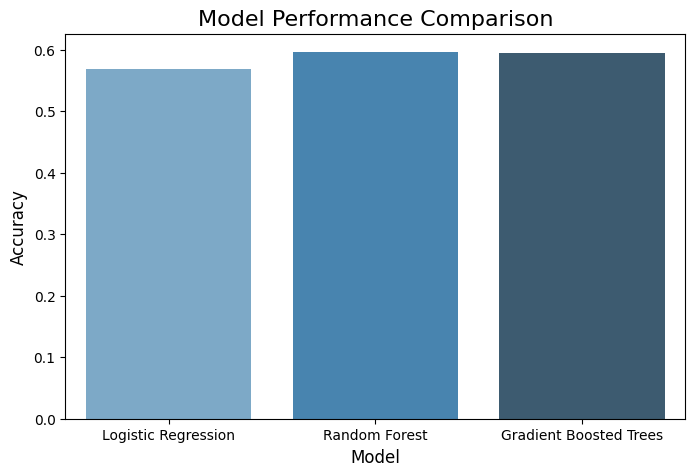

In [ ]:
# Model names and accuracies
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosted Trees']
accuracies = [0.5692, 0.5963, 0.5951]

# Create a bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette='Blues_d')

# Adding title and labels
plt.title('Model Performance Comparison', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Display the plot
plt.show()